<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/workbook_10_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to use demo**
* Drag and drop color circles to set features on the field
* Dropping feature outside the field removes it
* Panels "class A" and "class B" contain infinite supply for features
* Press button to process features with SVM

**Problem**

Use the following demo to get intuition behind SVM.
Check how moving features changes the result.

* You can restart the upper block of code without restarting the visualization part.
This way you can alter parameters of SVM without changing features positon -- just press "Invoke SVM" after you modified and restarted the upper block of the code.

Be sure to check that you understand how margins softening influences the result. 
I have tested $C=10^{-5}$ as a soft margin and $C=10^5$ as a hard margin, but you are encouraged to test other values.


#Linear kernel

In [156]:
import numpy as np
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=1E5, max_iter=10)

def fit_model(X, y):
  model.fit(X, y)

def predict_result(X):
  return model.predict(X)

def decision_function(X):
  return model.decision_function(X)

def support_vectors():
  return model.support_vectors_

In [ ]:
#@title Two classes SVM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize(X, y):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +1]
  ylim = [-1, +1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  #Z = predict_result(np.c_[xx.ravel(), yy.ravel()])
  Z = decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  
  sv = support_vectors()
  ax.scatter(sv[:, 0], sv[:, 1], s=500, c='y', linewidth=2, alpha=.9);
  # Put the result into a color plot
  n_classes = 5
  #Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, np.sign(Z), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2]

  fit_model(X, y)
  fig = visualize(X, y)

  return IPython.display.JSON({'image': figure_to_base64(fig)})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1A" name="rate" value="add0" checked="checked"> 
    <label for="r1A">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    </label><br>
    <input type="radio" id="r1B" name="rate" value="add1">
    <label for="r1B">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    </label><br>
    <input type="radio" id="r2" name="rate" value="move">
    <label for="r2">
    Move data point
    </label><br>
    <input type="radio" id="r3" name="rate" value="del">
    <label for="r3">
    Delete data point
    </label><br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''

display(IPython.display.HTML(main_str))
    
output.register_callback('notebook.InvSVM', invoke)

In [ ]:
#@title # SVM problems

%%html

<div id="all_slides">

<div>
You are classfying RED and BLUE classes with SVM.
RED class has 1 support vector and BLUE class has 2.
You've removed one of the blue support vectors.
May the decision boundary change?
<table class="question_style">
<tr><td class="ok">A) Yes</td></tr>
<tr><td>B) No</td></tr>
</table>
</div>

<div>
Will the decision boundary change, if you remove the non-support vector from the data?
<table class="question_style">
<tr><td>A) True</td></tr>
<tr><td class="ok">B) False</td></tr>
</table>
</div>

<div>
What is the meaning of a generalization error in terms of SVM?
<table class="question_style">
<tr><td>A) How far the hyperplane is from the support vectors</td></tr>
<tr><td class="ok">B) How accurately the SVM can predict outcomes for unseen data</td></tr>
<tr><td>C) The threshold amount of error in an SVM</td></tr>
</table>
</div>

<div>
When the C parameter is set to infinite, which of the following holds true?
<table class="question_style">
<tr><td class="ok">A) The optimal hyperplane if exists, will be the one that completely separates the data</td></tr>
<tr><td>B) The soft-margin classifier will separate the data</td></tr>
<tr><td>C) None of the above</td></tr>
</table>
</div>
 
<div>
What does a hard margin (large C) mean in terms of SVM?
<table class="question_style">
<tr><td class="ok">A) The SVM allows very low error in classification</td></tr>
<tr><td>B) The SVM allows high amount of error in classification</td></tr>
<tr><td>C) None of the above</td></tr>
</table>
</div>
 
<div>
Support vectors are the data points that lie closest to the decision surface.
<table class="question_style">
<tr><td class="ok">A) TRUE</td></tr>
<tr><td>B) FALSE</td></tr>
</table>
</div>

<div>
The SVM’s are less effective when:
<table class="question_style">
<tr><td>A) The data is linearly separable</td></tr>
<tr><td>B) The data is clean and ready to use</td></tr>
<tr><td class="ok">C) The data is noisy and contains overlapping points</td></tr>
</table>
</div>

<div>
The cost parameter in the SVM means:
<table class="question_style">
<tr><td>A) The number of cross-validations to be made</td></tr>
<tr><td>B) The kernel to be used</td></tr>
<tr><td class="ok">C) The tradeoff between misclassification and simplicity of the model</td></tr>
<tr><td>D) None of the above</td></tr>
</table>
</div>

 
<div>
What would happen when you use very small C (C~0)?
<table class="question_style">
<tr><td class="ok">A) Misclassification would happen</td></tr>
<tr><td>B) Data will be correctly classified</td></tr>
<tr><td>C) Can’t say</td></tr>
<tr><td>D) None of these</td></tr>
</table>
</div>

<div>
I've used all features of my dataset and achieved 100% accuracy on my training set, but ~70% on validation set.
What should I look out for?
<table class="question_style">
<tr><td>A) Underfitting</td></tr>
<tr><td>B) Nothing, the model is perfect</td></tr>
<tr><td class="ok">C) Overfitting</td></tr>
</table>
</div>


<div>
Question Context:<br>
Suppose you have trained an SVM with linear decision boundary.
You correctly infer that your SVM model is under fitting (low score on train set).<br>
Which of the following option would you more likely to consider iterating SVM next time?
<table class="question_style">
<tr><td>A) You want to increase your data points</td></tr>
<tr><td>B) You want to decrease your data points</td></tr>
<tr><td class="ok">C) You will try to calculate more variables</td></tr>
<tr><td>D) You will try to reduce the features</td></tr>
</table>
</div>
 
<div>
Question Context:<br>
Suppose you have trained an SVM with linear decision boundary.
You correctly infer that your SVM model is under fitting (low score on train set).<br>
Suppose you gave the correct answer in previous question.
What is actually happening?
<ol>
<li>We are lowering the bias</li>
<li>We are lowering the variance</li>
<li>We are increasing the bias</li>
<li>We are increasing the variance</li>
</ol>
<table class="question_style">
<tr><td>A) 1 and 2</td></tr>
<tr><td>B) 2 and 3</td></tr>
<tr><td class="ok">C) 1 and 4</td></tr>
<tr><td>D) 2 and 4</td></tr>
</table>
</div>
 
<div>
Question Context:<br>
Suppose you have trained an SVM with linear decision boundary.
You correctly infer that your SVM model is underfitting (low score on train set).<br>
Suppose you want to change one of it’s(SVM) hyperparameter so that effect would be same as previously, i.e model will not underfit?
<table class="question_style">
<tr><td class="ok">A) We will increase the parameter C</td></tr>
<tr><td>B) We will decrease the parameter C</td></tr>
<tr><td>C) Changing in C don’t effect</td></tr>
<tr><td>D) None of these</td></tr>
</table>
</div>
 



</div>

<div style="position:absolute; top:30px; left:900px;">

<div id="arrow_left" style="border-width: 1px; border-style:solid; float:left; height:32px;">
<svg width="8.7464mm" height="8.7464mm" version="1.1" viewBox="0 0 8.7464 8.7464" xmlns="http://www.w3.org/2000/svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
<metadata>
<rdf:RDF>
<cc:Work rdf:about="">
<dc:format>image/svg+xml</dc:format>
<dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
<dc:title/>
</cc:Work>
</rdf:RDF>
</metadata>
<g transform="translate(-38.564 -29.908)">
<rect x="38.564" y="29.908" width="8.7464" height="8.7464" fill-opacity=".16425" opacity=".97" stroke-miterlimit="10.433" stroke-width="0"/>
<path d="m45.796 34.331h-5.8931" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m40.068 34.267 2.7141-2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m40.069 34.396 2.7141 2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
</g>
</svg>
</div>

<div id="arrow_right" style="border-width: 1px; border-style:solid; float:right; height:32px;">
<svg width="8.7464mm" height="8.7464mm" version="1.1" viewBox="0 0 8.7464 8.7464" xmlns="http://www.w3.org/2000/svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
<metadata>
<rdf:RDF>
<cc:Work rdf:about="">
<dc:format>image/svg+xml</dc:format>
<dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
<dc:title/>
</cc:Work>
</rdf:RDF>
</metadata>
<g transform="translate(-38.564 -29.908)">
<rect transform="scale(-1,1)" x="-47.31" y="29.908" width="8.7464" height="8.7464" fill-opacity=".16425" opacity=".97" stroke-miterlimit="10.433" stroke-width="0"/>
<path d="m40.078 34.331h5.8931" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m45.806 34.267-2.7141-2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m45.805 34.396-2.7141 2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
</g>
</svg>
</div>

</div>

<style>
#arrow_left:hover{color:blue;}
#arrow_right:hover{color:blue;}
</style>

<script  type="text/javascript">
//var slides = ["slide_1", "slide_2", "slide_3"];

var container = document.getElementById("all_slides");
var menu_conn = document.createElement("div");
menu_conn.style.height = "90px";
menu_conn.id = "menu_div";
container.prepend(menu_conn);

// crutches
var slides = [];
var tmp = container.getElementsByTagName("div");
for (var i = 0; i < tmp.length; ++i)
  if (!tmp[i].id || tmp[i].id != "menu_div")
  {
    tmp[i].classList.add('slide_style');
    slides.push(tmp[i]);
  }


var left_btn_id = "arrow_left";
var right_btn_id = "arrow_right";
var current_slide = 0;
var menu = [];

function change_slide_to(new_slide_idx)
{
  menu[current_slide].style.borderWidth = "0px";
  var old_slide = slides[current_slide]; //document.getElementById(slides[current_slide]);
  current_slide = new_slide_idx;
  menu[current_slide].style.borderWidth = "2px";
  var new_slide = slides[current_slide]; //document.getElementById(slides[current_slide]);
  old_slide.style.display='none';
  new_slide.style.display='block';
}

function slide_left()
{
  var new_idx = current_slide - 1;
  if (new_idx < 0) {new_idx = 0;}
  change_slide_to(new_idx);
}

function slide_right()
{
  var new_idx = current_slide + 1;
  if (new_idx >= slides.length) {new_idx = slides.length - 1;}
  change_slide_to(new_idx);
}

function change(obj, is_correct)
{
//   alert(obj.parentNode.rowIndex);
    var rowId = obj.parentNode.rowIndex;
    var table = obj.parentNode.parentNode.parentNode;
    var rowsNotSelected = table.getElementsByTagName('tr');
    for (var row = 0; row < rowsNotSelected.length; row++)
    {
        rowsNotSelected[row].cells[0].style.backgroundColor = "white";
    }
    var rowSelected = table.getElementsByTagName('tr')[rowId];
    if (is_correct > 0)
    {
        rowSelected.cells[0].style.backgroundColor = "#66bb6aa9";
        menu[current_slide].style.backgroundColor = "#66bb6aa9";
    }
    else
    {
        rowSelected.cells[0].style.backgroundColor = "#ff3a3981";
        menu[current_slide].style.backgroundColor = "#ff3a3981";
    }
}

function make_callback(obj, is_correct)
{
  return function() { change(obj, is_correct); }
}

function change_callback(new_idx)
{
  return function() { change_slide_to(new_idx); }
}

document.getElementById(left_btn_id).addEventListener("click", slide_left);
document.getElementById(right_btn_id).addEventListener("click", slide_right);
slides[current_slide].style.display='block'; //document.getElementById(slides[current_slide]).style.display='block';

// create upper menu
upper_menu = document.getElementById("menu_div");

var tbl      = document.createElement("table");
var tbl_body = document.createElement("tbody");
var tbl_row  = document.createElement("tr");
for (idx = 0; idx < slides.length; idx++)
{
    var tbl_cell = document.createElement("td");
    var cell_text = document.createTextNode(idx+1);
    tbl_cell.appendChild(cell_text);
    tbl_cell.onclick = change_callback(idx);
    tbl_row.appendChild(tbl_cell);
    menu.push(tbl_cell);
    tbl_cell.style.borderWidth = "0px";

    var slide = slides[idx]; //document.getElementById(slides[idx]);
    var all_tables = slide.getElementsByTagName("table");
    for (t_i = 0; t_i < all_tables.length; t_i++)
    {
      var table = all_tables[t_i];
      if (!table.classList.contains("question_style"))
        continue;
      var rows = table.getElementsByTagName('tr');
      for (r_i = 0; r_i < rows.length; r_i++)
      {
        var question_cell = rows[r_i].cells[0];
        question_cell.classList.add("highlight");
        if (question_cell.classList.contains("ok"))
        {
          question_cell.onclick = make_callback(question_cell, 1);
        } else {
          question_cell.onclick = make_callback(question_cell, 0);
        }
        

        var cell = rows[r_i].insertCell(0);
        cell.width = "50px";
      }
    }
}
tbl_body.appendChild(tbl_row);
tbl.appendChild(tbl_body);
upper_menu.appendChild(tbl);
tbl.classList.add('menu_style');
menu[current_slide].style.borderWidth = "2px";

</script>

<style>
    .slide_style {
      max-width:750px;
      display:none;
      font: 14pt/18pt sans-serif;
      position: static;
      top: 80px;
      left: 0px;
    }

    .question_style {
        width:600px;
        font: 16pt/14pt sans-serif bold;
        text-align:left;
        cursor: default;
    }
    .question_style td{ 
        padding:7px;
        height: 50px;
        border:#4e95f4 0px solid;
        text-align:left;
        font: 13pt/16pt sans-serif;
    }
    .highlight:hover{
        background-color: #00000019
    }
    .menu_style {
        height:50px;
        font: 16pt/14pt sans-serif bold;
        text-align:left;
        cursor: default;
    }    
    .menu_style td{ 
        width:50px;
        padding:7px;
        border:#787878ff solid;
        text-align:center;
        font: 16pt/14pt sans-serif;
        color: #606060ff;
    }
</style>


A) Yes
B) No
A) True
B) False
A) How far the hyperplane is from the support vectors
B) How accurately the SVM can predict outcomes for unseen data
C) The threshold amount of error in an SVM
"A) The optimal hyperplane if exists, will be the one that completely separates the data"
B) The soft-margin classifier will separate the data
C) None of the above
A) The SVM allows very low error in classification


#Arbitrary kernel

In [ ]:
import numpy as np
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=1E5, gamma='auto')

def fit_model(X, y):
  model.fit(X, y)

def predict_result(X):
  return model.predict(X)

In [ ]:
#@title Arbitrary Kernel SVM code

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize(X, y):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +1]
  ylim = [-1, +1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  Z = predict_result(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  n_classes = 5
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=ListedColormap(rgb), zorder=1)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2]

  fit_model(X, y)
  fig = visualize(X, y)

  return IPython.display.JSON({'image': figure_to_base64(fig)})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1" name="rate" value="add0" checked="checked"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    <br>
    <input type="radio" id="r1" name="rate" value="add1"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    <br>
    <input type="radio" id="r1" name="rate" value="add2"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(2); "> Add class C
    <br>
    <input type="radio" id="r1" name="rate" value="add3"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(3); "> Add class D
    <br>
    <input type="radio" id="r1" name="rate" value="add4"> 
    <img src="" onerror="this.onerror=null; this.src = getImageURL(4); "> Add class E
    <br>
    <input type="radio" id="r2" name="rate" value="move"> Move data point
    <br>
    <input type="radio" id="r3" name="rate" value="del"> Delete data point
    <br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''

display(IPython.display.HTML(main_str))
    
output.register_callback('notebook.InvSVM', invoke)

In [ ]:
#@title # SVM problems

%%html

<div id="all_slides">


<div>
The minimum time complexity for training an SVM is O(n<sup>2</sup>).
According to this fact, what sizes of datasets are not best suited for SVM’s?
<table class="question_style">
<tr><td class="ok">A) Large datasets</td></tr>
<tr><td>B) Small datasets</td></tr>
<tr><td>C) Medium sized datasets</td></tr>
<tr><td>D) Size does not matter</td></tr>
</table>
</div>

<div>
The effectiveness of SVM depends upon:
<table class="question_style">
<tr><td>A) Selection of Kernel</td></tr>
<tr><td>B) Kernel Parameters</td></tr>
<tr><td>C) Soft Margin Parameter C</td></tr>
<tr><td class="ok">D) All of the above</td></tr>
</table>
</div>
 
<div>
Suppose you are using RBF kernel in SVM with high Gamma value.
What does this signify?
<table class="question_style">
<tr><td>A) The model would consider even far away points from hyperplane for modeling</td></tr>
<tr><td class="ok">B) The model would consider only the points close to the hyperplane for modeling</td></tr>
<tr><td>C) The model would not be affected by distance of points from hyperplane for modeling</td></tr>
<tr><td>D) None of the above</td></tr>
</table>
</div>

<div>
Suppose you are building a SVM model on data X.
The data X can be error prone which means that you should not trust any specific data point too much.
Now think that you want to build a SVM model which has quadratic kernel function of polynomial degree 2 that uses Slack variable C as one of it’s hyper parameter. Based upon that give the answer for following question. What would happen when you use very large value of C(C->infinity)?
<p style="color:red;">Note: For medium C all data points were classified correctly</p>
<table class="question_style">
<tr><td class="ok">A) We can still classify data correctly for given setting of hyper parameter C</td></tr>
<tr><td>B) We can not classify data correctly for given setting of hyper parameter C</td></tr>
<tr><td>C) Can’t Say</td></tr>
<tr><td>D) None of these</td></tr>
</table>
</div>

<div>
Which of the following are real world applications of the SVM?
<table class="question_style">
<tr><td>A) Text and Hypertext Categorization</td></tr>
<tr><td>B) Image Classification</td></tr>
<tr><td>C) Clustering of News Articles</td></tr>
<tr><td class="ok">D) All of the above</td></tr>
</table>
</div>
 
<div>
We usually use feature normalization before using the Gaussian kernel in SVM.
What is true about feature normalization?
<ol>
<li>We do feature normalization so that new feature will dominate other</li>
<li>Some times, feature normalization is not feasible in case of categorical variables</li>
<li>Feature normalization always helps when we use Gaussian kernel in SVM</li>
</ol>
<table class="question_style">
<tr><td>A) 1</td></tr>
<tr><td class="ok">B) 1 and 2</td></tr>
<tr><td>C) 1 and 3</td></tr>
<tr><td>D) 2 and 3</td></tr>
</table>
</div>


<div>
Question Context:<br>
Suppose you are dealing with 4 class classification problem and you want to train a SVM model on the data for that you are using One-vs-all method.<br>
How many times we need to train our SVM model in such case?
<table class="question_style">
<tr><td>A) 1</td></tr>
<tr><td>B) 2</td></tr>
<tr><td>C) 3</td></tr>
<tr><td class="ok">D) 4</td></tr>
</table>
</div>

<div>
Question Context:<br>
Suppose you are dealing with 4 class classification problem and you want to train a SVM model on the data for that you are using One-vs-all method.<br>
Suppose you have same distribution of classes in the data.
Now, say for training 1 time in one vs all setting the SVM is taking 10 second.
How many seconds would it require to train one-vs-all method end to end?
<table class="question_style">
<tr><td>A) 20</td></tr>
<tr><td class="ok">B) 40</td></tr>
<tr><td>C) 60</td></tr>
<tr><td>D) 80</td></tr>
</table>
</div>
 
<div>
Question Context:<br>
Suppose you are dealing with 4 class classification problem and you want to train a SVM model on the data for that you are using One-vs-all method.<br>
Suppose your problem has changed now. Now, data has only 2 classes.
What would you think how many times we need to train SVM in such case?
<table class="question_style">
<tr><td class="ok">A) 1</td></tr>
<tr><td>B) 2</td></tr>
<tr><td>C) 3</td></tr>
<tr><td>D) 4</td></tr>
</table>
</div>

<div>
Question context:<br>
Suppose you are using SVM with linear kernel of polynomial degree 2.
You have applied it to data and it perfectly fits.
Training and testing accuracies are 100%.<br>
You increase the complexity (i.e. degree of polynomial) of this kernel.
What would you think will happen?
<table class="question_style">
<tr><td class="ok">A) Increasing the complexity will overfit the data</td></tr>
<tr><td>B) Increasing the complexity will underfit the data</td></tr>
<tr><td>C) Nothing will happen since your model was already 100% accurate</td></tr>
<tr><td>D) None of these</td></tr>
</table>
</div>

<div>
Question context:<br>
Suppose you are using SVM with linear kernel of polynomial degree 2.
You have applied it to data and it perfectly fits.
Training and testing accuracies are 100%.<br>
After increasing complexity you found out that training accuracy was still 100%.
What can be the reason behind?
<ol>
<li>Since data is fixed and we are fitting more polynomial term or parameters so the algorithm starts memorizing everything in the data</li>
<li>Since data is fixed, SVM doesn’t need to search in big hypothesis space</li>
</ol>
<table class="question_style">
<tr><td>A) 1</td></tr>
<tr><td>B) 2</td></tr>
<tr><td class="ok">C) 1 and 2</td></tr>
<tr><td>D) None of these</td></tr>
</table>
</div>

<div>
What is/are true about kernel in SVM?
<ol>
<li>Kernel function maps low dimensional data to high dimensional space</li>
<li>It’s a similarity function</li>
</ol>
<table class="question_style">
<tr><td>A) 1</td></tr>
<tr><td>B) 2</td></tr>
<tr><td class="ok">C) 1 and 2</td></tr>
<tr><td>D) None of these</td></tr>
</table>
</div>

</div>

<div style="position:absolute; top:30px; left:900px;">

<div id="arrow_left" style="border-width: 1px; border-style:solid; float:left; height:32px;">
<svg width="8.7464mm" height="8.7464mm" version="1.1" viewBox="0 0 8.7464 8.7464" xmlns="http://www.w3.org/2000/svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
<metadata>
<rdf:RDF>
<cc:Work rdf:about="">
<dc:format>image/svg+xml</dc:format>
<dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
<dc:title/>
</cc:Work>
</rdf:RDF>
</metadata>
<g transform="translate(-38.564 -29.908)">
<rect x="38.564" y="29.908" width="8.7464" height="8.7464" fill-opacity=".16425" opacity=".97" stroke-miterlimit="10.433" stroke-width="0"/>
<path d="m45.796 34.331h-5.8931" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m40.068 34.267 2.7141-2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m40.069 34.396 2.7141 2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
</g>
</svg>
</div>

<div id="arrow_right" style="border-width: 1px; border-style:solid; float:right; height:32px;">
<svg width="8.7464mm" height="8.7464mm" version="1.1" viewBox="0 0 8.7464 8.7464" xmlns="http://www.w3.org/2000/svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
<metadata>
<rdf:RDF>
<cc:Work rdf:about="">
<dc:format>image/svg+xml</dc:format>
<dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
<dc:title/>
</cc:Work>
</rdf:RDF>
</metadata>
<g transform="translate(-38.564 -29.908)">
<rect transform="scale(-1,1)" x="-47.31" y="29.908" width="8.7464" height="8.7464" fill-opacity=".16425" opacity=".97" stroke-miterlimit="10.433" stroke-width="0"/>
<path d="m40.078 34.331h5.8931" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m45.806 34.267-2.7141-2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m45.805 34.396-2.7141 2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
</g>
</svg>
</div>

</div>

<style>
#arrow_left:hover{color:blue;}
#arrow_right:hover{color:blue;}
</style>

<script  type="text/javascript">
//var slides = ["slide_1", "slide_2", "slide_3"];

var container = document.getElementById("all_slides");
var menu_conn = document.createElement("div");
menu_conn.style.height = "90px";
menu_conn.id = "menu_div";
container.prepend(menu_conn);

// crutches
var slides = [];
var tmp = container.getElementsByTagName("div");
for (var i = 0; i < tmp.length; ++i)
  if (!tmp[i].id || tmp[i].id != "menu_div")
  {
    tmp[i].classList.add('slide_style');
    slides.push(tmp[i]);
  }


var left_btn_id = "arrow_left";
var right_btn_id = "arrow_right";
var current_slide = 0;
var menu = [];

function change_slide_to(new_slide_idx)
{
  menu[current_slide].style.borderWidth = "0px";
  var old_slide = slides[current_slide]; //document.getElementById(slides[current_slide]);
  current_slide = new_slide_idx;
  menu[current_slide].style.borderWidth = "2px";
  var new_slide = slides[current_slide]; //document.getElementById(slides[current_slide]);
  old_slide.style.display='none';
  new_slide.style.display='block';
}

function slide_left()
{
  var new_idx = current_slide - 1;
  if (new_idx < 0) {new_idx = 0;}
  change_slide_to(new_idx);
}

function slide_right()
{
  var new_idx = current_slide + 1;
  if (new_idx >= slides.length) {new_idx = slides.length - 1;}
  change_slide_to(new_idx);
}

function change(obj, is_correct)
{
//   alert(obj.parentNode.rowIndex);
    var rowId = obj.parentNode.rowIndex;
    var table = obj.parentNode.parentNode.parentNode;
    var rowsNotSelected = table.getElementsByTagName('tr');
    for (var row = 0; row < rowsNotSelected.length; row++)
    {
        rowsNotSelected[row].cells[0].style.backgroundColor = "white";
    }
    var rowSelected = table.getElementsByTagName('tr')[rowId];
    if (is_correct > 0)
    {
        rowSelected.cells[0].style.backgroundColor = "#66bb6aa9";
        menu[current_slide].style.backgroundColor = "#66bb6aa9";
    }
    else
    {
        rowSelected.cells[0].style.backgroundColor = "#ff3a3981";
        menu[current_slide].style.backgroundColor = "#ff3a3981";
    }
}

function make_callback(obj, is_correct)
{
  return function() { change(obj, is_correct); }
}

function change_callback(new_idx)
{
  return function() { change_slide_to(new_idx); }
}

document.getElementById(left_btn_id).addEventListener("click", slide_left);
document.getElementById(right_btn_id).addEventListener("click", slide_right);
slides[current_slide].style.display='block'; //document.getElementById(slides[current_slide]).style.display='block';

// create upper menu
upper_menu = document.getElementById("menu_div");

var tbl      = document.createElement("table");
var tbl_body = document.createElement("tbody");
var tbl_row  = document.createElement("tr");
for (idx = 0; idx < slides.length; idx++)
{
    var tbl_cell = document.createElement("td");
    var cell_text = document.createTextNode(idx+1);
    tbl_cell.appendChild(cell_text);
    tbl_cell.onclick = change_callback(idx);
    tbl_row.appendChild(tbl_cell);
    menu.push(tbl_cell);
    tbl_cell.style.borderWidth = "0px";

    var slide = slides[idx]; //document.getElementById(slides[idx]);
    var all_tables = slide.getElementsByTagName("table");
    for (t_i = 0; t_i < all_tables.length; t_i++)
    {
      var table = all_tables[t_i];
      if (!table.classList.contains("question_style"))
        continue;
      var rows = table.getElementsByTagName('tr');
      for (r_i = 0; r_i < rows.length; r_i++)
      {
        var question_cell = rows[r_i].cells[0];
        question_cell.classList.add("highlight");
        if (question_cell.classList.contains("ok"))
        {
          question_cell.onclick = make_callback(question_cell, 1);
        } else {
          question_cell.onclick = make_callback(question_cell, 0);
        }
        

        var cell = rows[r_i].insertCell(0);
        cell.width = "50px";
      }
    }
}
tbl_body.appendChild(tbl_row);
tbl.appendChild(tbl_body);
upper_menu.appendChild(tbl);
tbl.classList.add('menu_style');
menu[current_slide].style.borderWidth = "2px";

</script>

<style>
    .slide_style {
      max-width:750px;
      display:none;
      font: 14pt/18pt sans-serif;
      position: static;
      top: 80px;
      left: 0px;
    }

    .question_style {
        width:600px;
        font: 16pt/14pt sans-serif bold;
        text-align:left;
        cursor: default;
    }
    .question_style td{ 
        padding:7px;
        height: 50px;
        border:#4e95f4 0px solid;
        text-align:left;
        font: 13pt/16pt sans-serif;
    }
    .highlight:hover{
        background-color: #00000019
    }
    .menu_style {
        height:50px;
        font: 16pt/14pt sans-serif bold;
        text-align:left;
        cursor: default;
    }    
    .menu_style td{ 
        width:50px;
        padding:7px;
        border:#787878ff solid;
        text-align:center;
        font: 16pt/14pt sans-serif;
        color: #606060ff;
    }
</style>


A) Large datasets
B) Small datasets
C) Medium sized datasets
D) Size does not matter
A) Selection of Kernel
B) Kernel Parameters
C) Soft Margin Parameter C
D) All of the above
A) The model would consider even far away points from hyperplane for modeling
B) The model would consider only the points close to the hyperplane for modeling
C) The model would not be affected by distance of points from hyperplane for modeling


#Test area

In [ ]:
import numpy as np
import scipy.spatial.distance as dist


class Linear(object):
    def __call__(self, x, y):
        return np.dot(x, y.T)

    def __repr__(self):
        return "Linear kernel"


class Poly(object):
    def __init__(self, degree=2):
        self.degree = degree

    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree

    def __repr__(self):
        return "Poly kernel"


class RBF(object):
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        x = np.atleast_2d(x)
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(x, y) ** 2).flatten()

    def __repr__(self):
        return "RBF kernel"

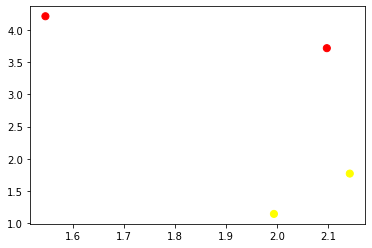

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=4, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

**SVM** is basically a binary linear classifier. Classes are called +1 and -1 and defined as
$$
\text{class} = \text{sign}\left(\vec{x} \cdot \vec{w} + b\right).
$$
I will call 
$$
\vec{x} \cdot \vec{w} + b
$$
a confidence function -- the more positive it is, the more confident is the classifier that this is +1, same true for -1.

ctrl -979 [10  2  3  5 12]
2.2675736961451247 0.0
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17
2.9620516736294804 -8.326672684688674e-17


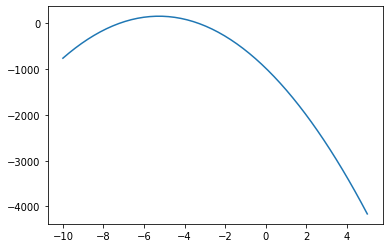

In [154]:
import numpy as np

def confidence(x, w, b):
  return np.dot(x, w) + b

def classify(x, w, b):
  return np.sign(confidence(x, w, b))

def kernel(x, y):
  return np.dot(x, y.T)

def get_matrix_K(x, y):
  return np.array([[y1*y2*kernel(x1, x2) for x1, y1 in zip(x, y)] for x2, y2 in zip(x, y)])

def get_matrix_M(K, idxI, idxJ):
  return np.array([[K[idxI, idxI], K[idxI, idxJ]],
                   [K[idxJ, idxI], K[idxJ, idxJ]]])

def get_vector_k(K, lambdas, idxI, idxJ):
  l = lambdas.copy()
  l[[idxI, idxJ]] = [0, 0]
  return np.array([2-2*np.sum(K[idxI] * l), 2-2*np.sum(K[idxJ] * l)])

def get_vector_v0(lambdas, idxI, idxJ):
  return np.array([lambdas[idxI], lambdas[idxJ]])


def get_vector_u(y, idxI, idxJ):
  return np.array([-y[idxJ], y[idxI]])

def get_L(v, M, k):
  return np.dot(k, v) - np.dot(np.dot(M, v), v)

def get_t_max(M, k, v0, u):
  return (np.dot(k, u) - np.dot(np.dot(M, u), v0) - np.dot(np.dot(M, v0), u)) / (2 * np.dot(np.dot(M, u), u))

def restrict_to_square(t, v0, u, C):
  if (v0 + t*u)[1] < 0:
    t = -v0[1]/u[1]
  if (v0 + t*u)[1] > C:
    t = (C-v0[1])/u[1]
  if (v0 + t*u)[0] < 0:
    t = -v0[0]/u[0]
  if (v0 + t*u)[0] > C:
    t = (C-v0[0])/u[0]
  return t

def get_b(K, y, lambdas, C):
  sum = 0.0
  cnt = 0
  for idx,l in enumerate(lambdas):
    #print(idx, l)
    if 0 < l < C:
      sum += y[idx] - np.sum(K[idx] * y[idx] * lambdas)
      cnt += 1
  return sum/cnt

x = np.array([[1,1], [2,2], [5,6], [-2,4], [1,0]])
y = np.array([1, -1, 1, 1, -1])
K = get_matrix_K(x, y)
l = np.array([10,2,3,5,12])

total_prod = (K.T*l).T*l
l0 = l.copy()
l0[[0, 2]] = [0, 0]
total_prod_excl = (K.T*l0).T*l0

total_sum = np.sum(total_prod)
excl_sum  = np.sum(total_prod_excl)
control_sum = total_sum - excl_sum
#print(K) 
#print((K.T*l).T*l)
print('ctrl', 2*(l[0] + l[2]) - control_sum, l)

M = get_matrix_M(K, 0, 2)
v = np.array([l[0], l[2]])
k = get_vector_k(K, l, 0, 2)
np.dot(k, v) - np.dot(np.dot(M, v), v)

t = np.linspace(-10,5,num=50)
v0 = get_vector_v0(l, 0, 2)
u = get_vector_u(y, 0, 2)
V = t[:,np.newaxis] * u + v0
L = np.array([get_L(v, M, k) for v in V])

import matplotlib.pyplot as plt
plt.plot(t, L)
get_t_max(M, k, v0, u)

lambdas = []
b = 0.0
K = []
max_iter = 10
C = 100000
X = []
y = []

def fit_model(X_, y_):
  global X
  X = X_
  global y
  y = y_
  #print(X, y)
  global lambdas
  lambdas = np.zeros_like(y, dtype=float)
  global b
  b = 0.0
  global K
  K = get_matrix_K(X, y)
  global max_iter
  #print(K)

  for _ in range(max_iter):
    for idxI in range(len(lambdas)):
      idxJ = idxI
      while idxJ == idxI: idxJ = np.random.randint(0, len(lambdas));
      #print('cycling ', idxI, idxJ, lambdas)
      M = get_matrix_M(K, idxI, idxJ)
      k = get_vector_k(K, lambdas, idxI, idxJ)
      v0 = get_vector_v0(lambdas, idxI, idxJ)
      L_old = get_L(v0, M, k)
      u = get_vector_u(y, idxI, idxJ)
      t_max = get_t_max(M, k, v0, u)
      t_max = restrict_to_square(t_max, v0, u, C)
      #print(t_max, v0 + u * t_max, get_L(v0 + u * t_max, M, k), np.dot(np.dot(M, u), u))
      v = v0 + u * t_max
      L = get_L(v, M, k)
      #if L > L_old:
      L_old = np.dot(np.dot(K, lambdas), lambdas)
      lambdas[idxI] = v[0]
      lambdas[idxJ] = v[1]
      #print(lambdas, v0, u, idxI, idxJ, L_old, L)
      L = np.dot(np.dot(K, lambdas), lambdas)
      if L_old > L:
        lambdas[idxI] = v0[0]
        lambdas[idxJ] = v0[1]
      else:
        print(L, np.sum(lambdas*y))
  #print(lambdas)
  b = get_b(K, y, lambdas, C)

#def predict_result(x_):
#  k = [for x in X]
#  return svm.predict(X)

def decision_function(X_):
  #print('decision: ', X_)
  result = []
  for x_ in X_:
    k = np.array([kernel(x, x_) for x in X])
    result.append(np.sum(k * y * lambdas) + b)
  return np.array(result)

#def support_vectors():
#  return model.support_vectors_

X = np.array([
              [-0.5,         0.37666667],
              [ 0.76,       -0.04333333],
              [ 0.42333333, -0.45      ]])
y = np.array([-1, 1, 1])
fit_model(X, y)


In [155]:
#@title Two classes SVM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def visualize(X, y):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  ax.tick_params(axis="y",direction="in", pad=-40)
  ax.tick_params(axis="x",direction="in", pad=-15)
  ax.set_xticks(np.arange(-.75, 1, .25))
  ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[(y+1)//2], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +1]
  ylim = [-1, +1]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator # 700
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  #####Z = predict_result(np.c_[xx.ravel(), yy.ravel()])
  Z = decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  
  #sv = support_vectors()
  #ax.scatter(sv[:, 0], sv[:, 1], s=500, c='y', linewidth=2, alpha=.9);
  # Put the result into a color plot
  n_classes = 5
  Z = Z.reshape(xx.shape)
  contours = ax.contourf(xx, yy, np.sign(Z), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)

  plt.close(fig)

  return fig

import base64
import io

def figure_to_base64(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0);
  image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
  buf.close()
  return image_base64

import json

def invoke(pts):
  data = np.array(pts).reshape((-1, 3))
  X = data[:, :2] / 300.0 - 1.0
  X[:, 1] *= -1.0
  y = data[:, 2] * 2 - 1

  fit_model(X, y)
  fig = visualize(X, y)

  return IPython.display.JSON({'image': figure_to_base64(fig)})


import IPython
from google.colab import output

main_str = '''
  <script type="application/javascript">
  
    var active_pt = null;
    var all_pts = [];
    var class_btn = [[650, 50], [650, 150], [650, 250], [650, 350], [650, 450]];
    var class_name = ["class A", "class B", "class C", "class D", "class E"];
    var class_color = ["rgba(210, 0, 0, 0.75)", "rgba(0, 0, 150, 0.75)", 
         "rgba(107, 142, 35, 0.95)", "rgba(150, 0, 150, 0.75)", "rgba(220, 105, 0, 0.75)"]

    var ptR = 10.0;
    var params = null;
    var debug_txt = "";
    var bg_image = new Image();

    function is_close(pt1, pt2) {
      return   (pt1[0] - pt2[0])*(pt1[0] - pt2[0])
            +  (pt1[1] - pt2[1])*(pt1[1] - pt2[1])
            <= ptR*ptR;
    }
  
    function circ(ctx, pos, cls) {
      ctx.beginPath();
      ctx.arc(pos[0], pos[1], ptR, 0.0, 2.0 * Math.PI, 0);
      ctx.fillStyle = class_color[cls];
      ctx.fill();
    }
    
    function draw() {
      var canvas = document.getElementById('canvas');
      if (canvas.getContext) {
        var ctx = canvas.getContext('2d');
        
        ctx.clearRect(0, 0, canvas.width, canvas.height); // cleanup before start
        ctx.drawImage(bg_image, 0, 0, 600, 600);
        ctx.strokeRect(0, 0, 600, 600); // field

        ctx.fillText(debug_txt, 200, 200);

        if (active_pt) {
          circ(ctx, [active_pt[0], active_pt[1]], active_pt[2]);
        }
        all_pts.forEach(function (item, index) {
          circ(ctx, [item[0], item[1]], item[2]);
        });

      }
    }
    
    var timer
    function init() {
      timer = setInterval(draw, 10);
    }

    function get_state() {
      var rates = document.getElementsByName('rate');
      for(var i = 0; i < rates.length; i++)
        if(rates[i].checked)
          return rates[i].value;
      return "none";
    }

    
    function mdown_handle(evt) {
      x = evt.offsetX;
      y = evt.offsetY;
      state = get_state();
      if (state.slice(0,3) == "add") {
        var class_idx = parseInt(state.slice(3,4), 10);
        if (x < 600)
            all_pts.push([x, y, class_idx]);
        return;
      }

      idx = -1;
      all_pts.forEach(function (item, index) {
        if (is_close([x,y], [item[0], item[1]])) {
          idx = index;
        }
      });
      if (idx <= -1)
          return;
      if (state == "move") {
        active_pt = all_pts[idx];
        all_pts.splice(idx, 1);
      }
      if (state == "del")
          all_pts.splice(idx, 1);
    }
    
    function mmove_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (active_pt) {
        active_pt[0] = x;
        active_pt[1] = y;
      }
    }
    
    function mup_handle(evt) {
      if (get_state() != "move")
          return;
      x = evt.offsetX;
      y = evt.offsetY;
      if (x >= 600) {
        active_pt = null;
      }
      if (active_pt) {
        all_pts.push(active_pt);
        active_pt = null;
      }
    }
    
    function clear_field() {
      active_pt = null;
      all_pts = [];
    }

    async function calculate() {
      if (!all_pts)
        return;
      var merged = [].concat.apply([], all_pts);
      const result = await google.colab.kernel.invokeFunction('notebook.InvSVM', [merged], {});
      params = result.data['application/json'];
      bg_image.src = 'data:image/  png;base64,' + params.image;
    }

  function getImageURL(class_idx)
  {
     var canvas = document.createElement('canvas');
     var ctx = canvas.getContext('2d');
     canvas.width  = 2.0 * ptR;
     canvas.height = 2.0 * ptR;
     circ(ctx, [ptR, ptR], class_idx);
     return canvas.toDataURL(); //image URL
  }

  </script>
  <canvas id="canvas" width="800" height="600" 
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)"></canvas>
  <div style="position:absolute; top:200px; left:625px;">
   <div style="border-style: solid;">
    <input type="radio" id="r1A" name="rate" value="add0" checked="checked"> 
    <label for="r1A">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(0); "> Add class A
    </label><br>
    <input type="radio" id="r1B" name="rate" value="add1">
    <label for="r1B">
    <img src="" onerror="this.onerror=null; this.src = getImageURL(1); "> Add class B
    </label><br>
    <input type="radio" id="r2" name="rate" value="move">
    <label for="r2">
    Move data point
    </label><br>
    <input type="radio" id="r3" name="rate" value="del">
    <label for="r3">
    Delete data point
    </label><br>
    <button type="button" onclick="clear_field();">
      Clear
    </button>
   </div>
   <br><br>
    <button type="button" onclick="calculate();">
      Invoke SVM
    </button>
  </div>
  <script> init();</script>
'''

display(IPython.display.HTML(main_str))
    
output.register_callback('notebook.InvSVM', invoke)

10.967250571210968 0.0
10.967250571210968 0.0
10.967250571210968 0.0
10.967250571210968 0.0
10.967250571210968 0.0
10.967250571210968 0.0
10.967250571210968 0.0
10.967250571210968 0.0
11.829706483260326 0.0
11.829706483260326 0.0
11.829706483260326 0.0
11.829706483260326 0.0
11.829706483260326 0.0
11.829706483260326 0.0
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.698843342628585 -8.881784197001252e-16
24.963416109291003 -8.881784197001252e-16
24.963416109291003 -8.881784197001252e-16
24.963416109291003 -8.881784197001252e-16
24.963

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [ ]:
# http://cs229.stanford.edu/materials/smo.pdf
# https://web.cs.dal.ca/~tt/CSCI650806/projects/papers/SmolaSchoelkopf.pdf
# http://cs229.stanford.edu/summer2020/cs229-notes3.pdf

import numpy as np

class SVM:
  def __init__(self, C=10.0, max_iter=100000):
    self.C = C
    self.max_iter = max_iter

  def kernel(self, x, y):
    return np.dot(x, y.T)

  def predict(self, X):
    return np.sign(self.decision_function(X)).astype(int)

#  def check_KKT(self, idx):
#    predict = self.y[idx] * self.decision_function(self.X[idx])
#    if 0 < self.alpha[idx] < self.C:
#      return np.abs(predict - 1.0) < 1E-4
#    if self.alpha[idx] <= 0:
#      return predict >= 1
#    if self.alpha[idx] >= self.C:
#      return predict <= 1

  def decision_function(self, X):
    return np.dot(X, self.w) + self.b

  def restrict_to_rectangle(self, idx1, idx2, restrict2):
    if self.y[idx1] == self.y[idx2]:
      restrict2 = np.max([0, self.alpha[idx1] + self.alpha[idx2] - self.C, restrict2])
      restrict2 = np.min([self.C, self.alpha[idx1] + self.alpha[idx2], restrict2])
    else:
      restrict2 = np.max([0, self.alpha[idx2] - self.alpha[idx1], restrict2])
      restrict2 = np.min([self.C, self.C + self.alpha[idx2] - self.alpha[idx1], restrict2])
    return restrict2

  def error(self, idx):
    return self.decision_function(self.X[idx]) - self.y[idx]

  def min_from_line(self, idx1, idx2):
    eta = 2*self.kernel(self.X[idx1], self.X[idx2]) - self.kernel(self.X[idx1], self.X[idx1]) - self.kernel(self.X[idx2], self.X[idx2])
    if -0.0001 < eta < 0.0001:
      return self.alpha[idx2]
    error1 = self.error(idx1)
    error2 = self.error(idx2)
    new_alpha2 = self.alpha[idx2] - self.y[idx2] * (error1 - error2) / eta
    new_alpha2 = self.restrict_to_rectangle(idx1, idx2, new_alpha2)
    return new_alpha2

  def b_by_alpha(self, idx1, idx2, delta1, delta2):
    return (self.b - self.error(idx1) 
                   - self.y[idx1] * delta1 * self.kernel(self.X[idx1], self.X[idx1]) 
                   - self.y[idx2] * delta2 * self.kernel(self.X[idx1], self.X[idx2]))

  def update_alphas(self, idx1, idx2):
    new_alpha_2 = self.min_from_line(idx1, idx2)
    new_alpha_1 = self.alpha[idx1] + self.y[idx1] * self.y[idx2] * (self.alpha[idx2] - new_alpha_2)
    b1 = self.b_by_alpha(idx1, idx2, new_alpha_1 - self.alpha[idx1], new_alpha_2 - self.alpha[idx2])
    b2 = self.b_by_alpha(idx2, idx1, new_alpha_2 - self.alpha[idx2], new_alpha_1 - self.alpha[idx1])
    if 0 < new_alpha_1 < self.C:
      self.b = b1
    elif 0 < new_alpha_2 < self.C:
      self.b = b2
    else:
      self.b = (b1 + b2) / 2.0
    self.alpha[idx1] = new_alpha_1
    self.alpha[idx2] = new_alpha_2

  def update_w(self):
      self.w = np.dot(self.X.T, np.multiply(self.alpha, self.y))

  def fit(self, X, y):
    self.X = X
    self.y = y
    self.alpha = np.zeros_like(y)
    self.w = np.zeros(X.shape[1])
    self.b = 0.0
    for _ in range(self.max_iter):
      for idx1 in range(len(self.alpha)):
        idx2 = np.random.randint(0, len(self.alpha))
        if idx1 == idx2:
          continue
        self.update_alphas(idx1, idx2)
        self.update_w()


svm = SVM(C=100000)

def fit_model(X, y):
  svm.fit(X, y)

def predict_result(X):
  return svm.predict(X)

def decision_function(X):
  return svm.decision_function(X)

def support_vectors():
  return model.support_vectors_

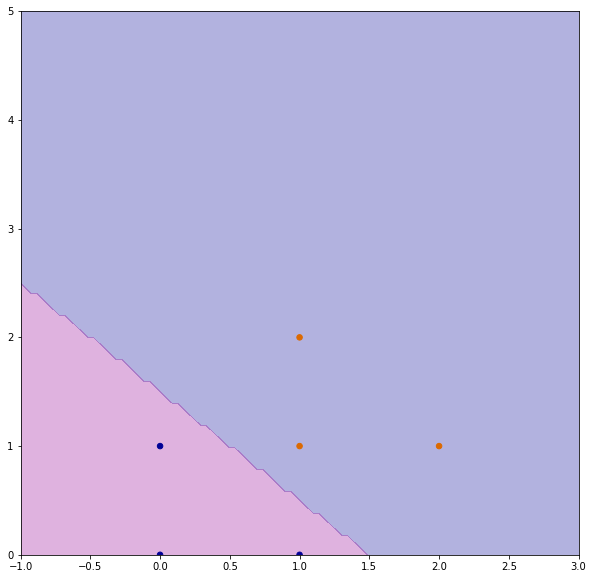

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize(X, y):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca()
  #ax.tick_params(axis="y",direction="in", pad=-40)
  #ax.tick_params(axis="x",direction="in", pad=-15)
  #ax.set_xticks(np.arange(-.75, 1, .25))
  #ax.set_yticks(np.arange(-.75, 1, .25))
  
  # Plot the training points
  rgb = [[210, 0, 0], [0, 0, 150], [107, 142, 35], [150, 0, 150], [220, 105, 0]]
    
  rgb=np.array(rgb)/255.
  ax.scatter(X[:, 0], X[:, 1], c=rgb[y], s=30, zorder=3)
  ax.axis('tight')
  xlim = [-1, +3]
  ylim = [+0, +5]
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  
  # fit the estimator
  xx, yy = np.meshgrid(np.linspace(*xlim, num=100), np.linspace(*ylim, num=100))
  Z = np.array([svm.predict(z) for z in np.c_[xx.ravel(), yy.ravel()]])

  # Put the result into a color plot
  n_classes = 5
  Z = Z.reshape(xx.shape)
  #print(Z)
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=[-1.0, 0.0, 1.0], cmap=ListedColormap(rgb), zorder=1)

  #plt.close(fig)

  #return fig
visualize(X, y)

In [ ]:
svm.predict(np.array([0.5, 1]))

1